### This exercise is based on tutorial from https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/ page. Thanks for this nice introductary tutorial. 

In [ ]:
#Libraries

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

#figure size
from IPython.core.pylabtools import figsize
figsize(10, 6)

# date parser 
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m')



## Read the Air passenger data with pandas read_csv

In [11]:
ts = pd.read_csv('Airpassengers.txt', header=0, parse_dates=[0], squeeze=True, index_col=0,date_parser=dateparse)

### Arguments 

#### parse_dates: Specifies the column with date-time information 
#### squeeze : If the parsed data only contains one column then return a Series (default is false)
#### index_col: Use 'this' column as the index of the series
#### date_parser: Convert input date time string into date time object



Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
Name: #Passengers, dtype: int64


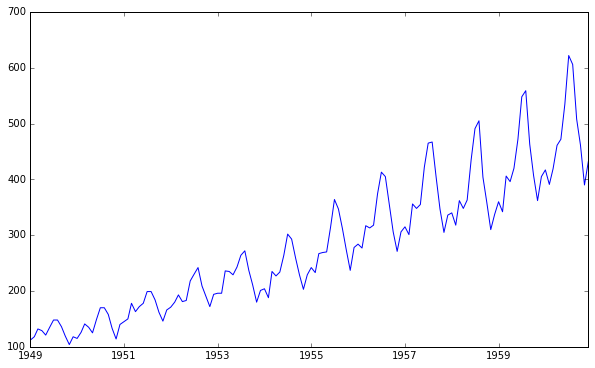

In [13]:

print ts.head()

plt.plot(ts)

plt.show()

#### Here the ts has time object as index and #Passengers as the column. We can cross-check the datatype of the index with the following command:

In [14]:
ts.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name=u'Month', length=144, freq=None)

#### We can use specific index as a string constant e.g.

In [15]:
ts['1949-02-01']

118

In [16]:
ts['1949-01-01':'1949-05-01']

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
Name: #Passengers, dtype: int64

In [17]:
ts['1949']

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
1949-06-01    135
1949-07-01    148
1949-08-01    148
1949-09-01    136
1949-10-01    119
1949-11-01    104
1949-12-01    118
Name: #Passengers, dtype: int64

### Stationarity of Time Series 

A time series is stationary if its mean and variance are constant over time. Most of the time series models work on the assumption that TS is stationary. If the series is non-stationary, the models are not good enough for easy implementatation. The sationarity of the time series can be done in following two ways:
1. Plotting Rolling Statistics
2. Dickey-Fuller Test

In [20]:
#Dickey Fuller test. Dickey-Fuller test can be used to test for a unit root in a univariate process 
#in the presence of serial correlation.

from statsmodels.tsa.stattools import adfuller 

def is_stationary(tseries):
    # caculate rolling mean and standard deviation 
    rolmean = tseries.rolling(window=12,center=False).mean() 
    rolstd = tseries.rolling(window=12,center=False).std()
    
    #plot the orginal TS, rolling mean and standard deviation 
    orig = plt.plot(tseries, color='blue', label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling mean')
    std = plt.plot(rolstd, color='black', label='Rolling Stdv') 
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    
    print 'Results of Dickey-Fuller Test:'
    
    dftest = adfuller(tseries, autolag='AIC') 
    
    # Ad fuller test returns test statistics, p-value, #of lags used, # of observation, critical value etc
    # see Documentation at http://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html
    
    dfoutput= pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '# of Lags used', '# of Observation used'])
    
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
        
    #print the results 
    
    print dfoutput

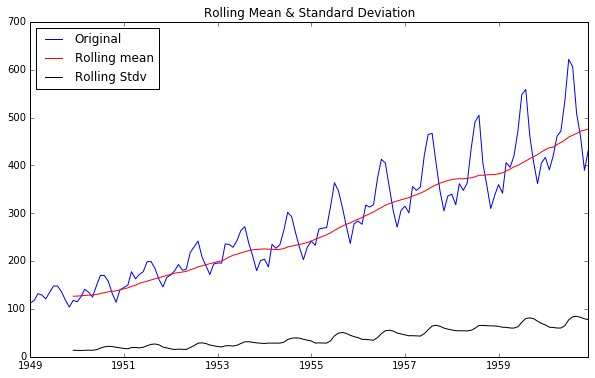

Results of Dickey-Fuller Test:
Test Statistic             0.815369
p-value                    0.991880
# of Lags used            13.000000
# of Observation used    130.000000
Critical Value (5%)       -2.884042
Critical Value (1%)       -3.481682
Critical Value (10%)      -2.578770
dtype: float64


In [22]:
is_stationary(ts)

Here the variation in standard deviation is small but mean is increasing with time. As a result, it is not a stationary time series. Also, the test statistics is way more than the critical values. Note that the signed values should be compared and not the absolute values. Now we want to make it a stationary time series. 

### So How do I make the ime tseries stationary? 

Even though TS models assume stationarity of the series, almost all practical time series is non-stationary. A series can be made practically stationary by modeling following adjustments:

1. Trend – varying mean over time. For eg, in this case we saw that on average, the number of passengers was growing over time.
2. Seasonality – variations at specific time-frames. eg people might have a tendency to buy cars in a particular month because of pay increment or festivals.

Once trend and seasonality is modeled we can make those adjustments to get stationary series and make forecast based on timeseries models. Trend and seasonality constraints are then applied to the forecasted values to convert to original values.

### Estimating and Eliminating Trend

####  By Tranformation
  a. Log transform

In [23]:
import numpy as np
ts_log = np.log(ts)

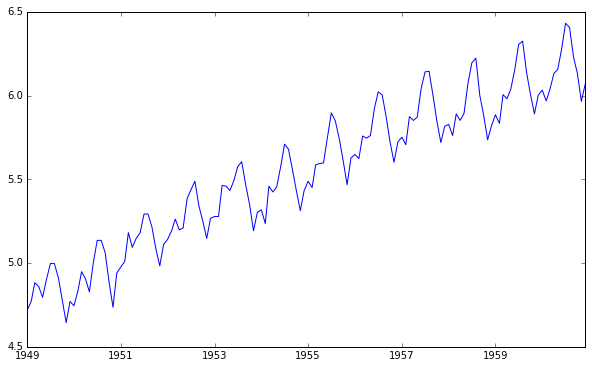

In [24]:
plt.plot(ts_log)

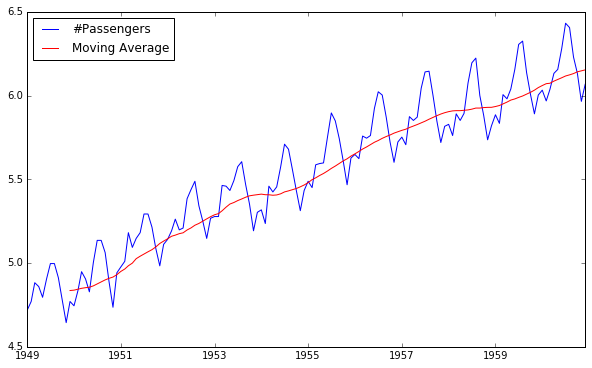

In [25]:
rol_avg = ts_log.rolling(window=12,center=False).mean() 
plt.plot(ts_log)
plt.plot(rol_avg, color='red', label='Moving Average')

plt.legend(loc='best')

Here, the red line represents the rolling mean. Let's subract it from the original (log transformed) series. 

In [26]:
ts_log_rol_avg_diff = ts_log - rol_avg

 Note that rol_avg is defined only for 12th value. Let's see if that's true: 

In [27]:
ts_log_rol_avg_diff.head(12)

Month
1949-01-01         NaN
1949-02-01         NaN
1949-03-01         NaN
1949-04-01         NaN
1949-05-01         NaN
1949-06-01         NaN
1949-07-01         NaN
1949-08-01         NaN
1949-09-01         NaN
1949-10-01         NaN
1949-11-01         NaN
1949-12-01   -0.065494
Name: #Passengers, dtype: float64

 Now let us drop NaN values and check if this series is stationary 

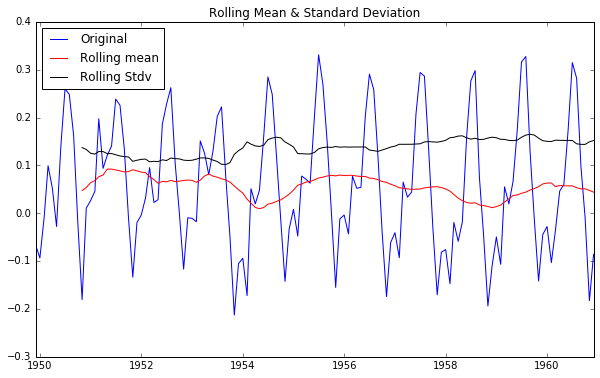

Results of Dickey-Fuller Test:
Test Statistic            -3.162908
p-value                    0.022235
# of Lags used            13.000000
# of Observation used    119.000000
Critical Value (5%)       -2.886151
Critical Value (1%)       -3.486535
Critical Value (10%)      -2.579896
dtype: float64


In [29]:
ts_log_rol_avg_diff.dropna(inplace=True)

is_stationary(ts_log_rol_avg_diff)

This is a much better series in terms of stationarity. The rolling mean my be slowly varying but there is no definitive trend. Also, the test statistics for Dickey-fuller test is smaller than the 5% critical value so we can say with 95% confidence that this is a stationary series. One drawbaack in this particular approach is that the time period has to be strictly defined, which may not always be easy. In situations like stock price forecasting, it is much more difficult to come up with some number like yearly or monthly average. In that case 'weighted moving average' is the way to go. One popular method is to use exponentially weighted moving average. 

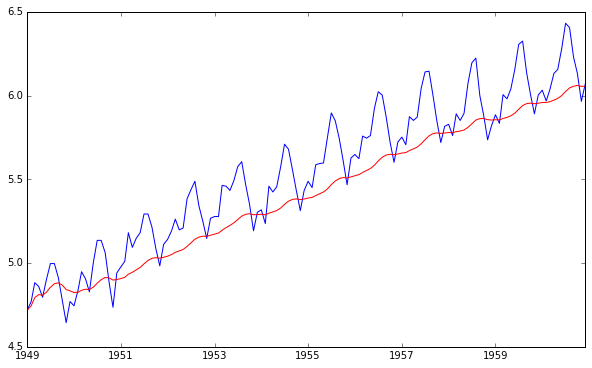

In [32]:
expWMA = ts_log.ewm(halflife = 12).mean()
plt.plot(ts_log)
plt.plot(expWMA, color='red')

Here the red line represents the exponentially weighted moving average. Let's subtract is from the original ( log transformed) time series

In [33]:
ts_log_ewma_diff = ts_log - expWMA

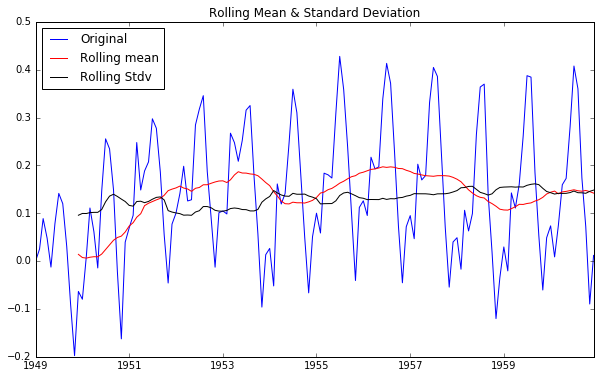

Results of Dickey-Fuller Test:
Test Statistic            -3.601262
p-value                    0.005737
# of Lags used            13.000000
# of Observation used    130.000000
Critical Value (5%)       -2.884042
Critical Value (1%)       -3.481682
Critical Value (10%)      -2.578770
dtype: float64


In [34]:
is_stationary(ts_log_ewma_diff) #is it stationary now ? 

This has even lesser variation in mean and standard deviation and the test statistics is smaller than 1% critical value. Also note that there are no missing values as ewma is defined for all intervals. 

## Eliminating Trend and Seasonality

The simple trend reduction techniques discussed before don't work in case where seasonality is high. we can remove trend and seasonality in these cases by following methods: 
1. Differencing- Taking the difference with particular time lag
2. Decomposition- Modeling both trend and seasonality and removing them from the model

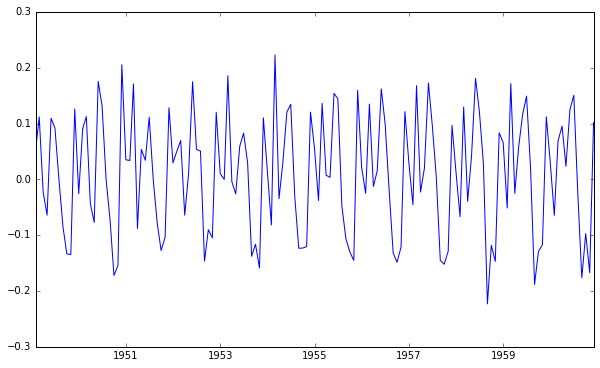

In [35]:
# Differencing 
ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff)

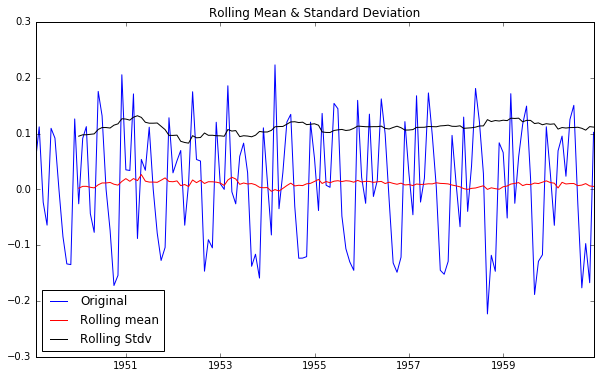

Results of Dickey-Fuller Test:
Test Statistic            -2.717131
p-value                    0.071121
# of Lags used            14.000000
# of Observation used    128.000000
Critical Value (5%)       -2.884398
Critical Value (1%)       -3.482501
Critical Value (10%)      -2.578960
dtype: float64


In [36]:
ts_log_diff.dropna(inplace=True)
is_stationary(ts_log_diff)

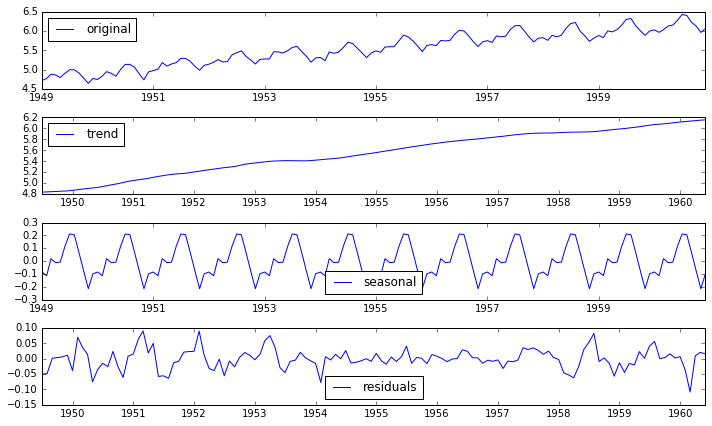

In [37]:
# Decomposition 

from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(ts_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='original')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='trend')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal, label='seasonal')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residual, label='residuals')
plt.legend(loc='best')

plt.tight_layout()

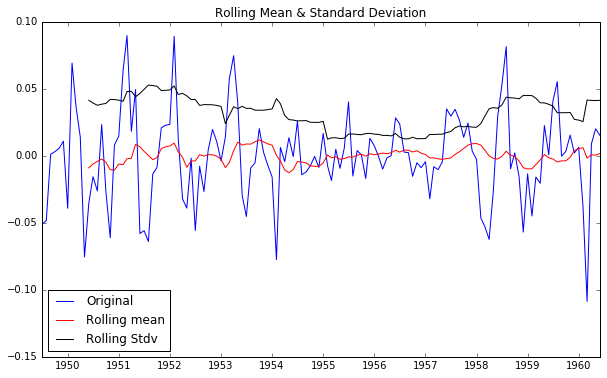

Results of Dickey-Fuller Test:
Test Statistic          -6.332387e+00
p-value                  2.885059e-08
# of Lags used           9.000000e+00
# of Observation used    1.220000e+02
Critical Value (5%)     -2.885538e+00
Critical Value (1%)     -3.485122e+00
Critical Value (10%)    -2.579569e+00
dtype: float64


In [39]:
ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)
is_stationary(ts_log_decompose)

### Now Forecasting a Time Series:
We saw many different technique to make the TS stationary. Now, let's make model on the time series after 'differencing' as it is a very popular technique. Also, its relatively easier to add noise and seasonality back into predicted residuals in this case.

### ARIMA (Auto-Regressive Integrated Moving Average) :
The ARIMA forecasting for a stationary time series like a linear (like linear regression) equation x(t) = alpha *  x(t – 1) + error (t). The predictors depend on the parameters (p,d,q) of the ARIMA model (https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average), where p is the number of auto-regression terms, d is the number of non seasonal differences, and q is the number of moving average terms. To determine the value of p and q let's plot auto correlation and partial auto correlation functions for our time series.  

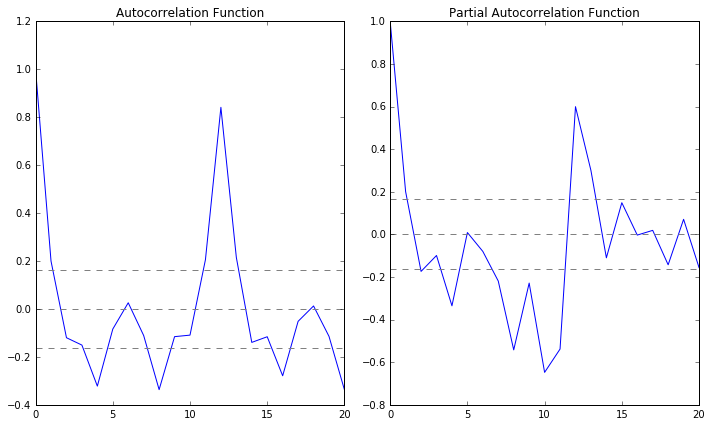

In [40]:
#autocorrelation function (acf) and partial auto-correlation function (pacf)
from statsmodels.tsa.stattools import acf, pacf

lag_acf = acf(ts_log_diff, nlags=20)
lag_pacf = pacf(ts_log_diff, nlags=20, method='ols')

plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')


#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()


In these plots the dotted lines are the confidence intervals, which are used to determine p and q. p is the lag value where PACF crosses confidence interval for first time (p=2). q is the lag value where ACF crosses confidence interval for first time (q=2). The p,d,q values can be specified using the order argument of ARIMA which take a tuple (p,d,q). Let model the 3 cases:

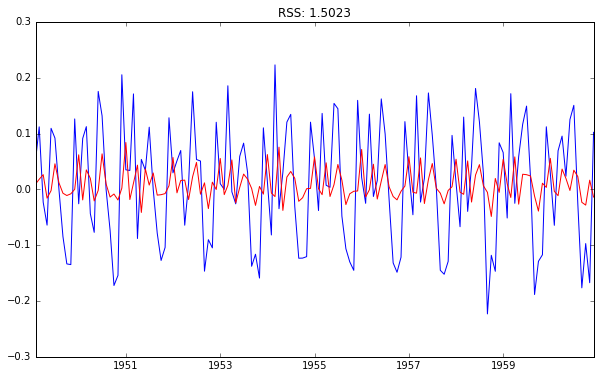

In [43]:
#AR Model
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(ts_log, order=(2, 1, 0))  
results_AR = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-ts_log_diff)**2))


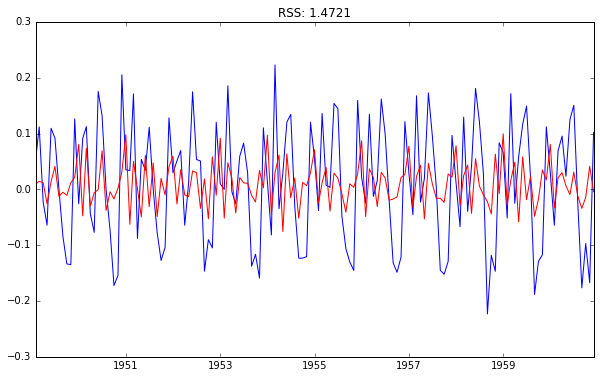

In [44]:
#MA Model

model = ARIMA(ts_log, order=(0, 1, 2))  
results_MA = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-ts_log_diff)**2))

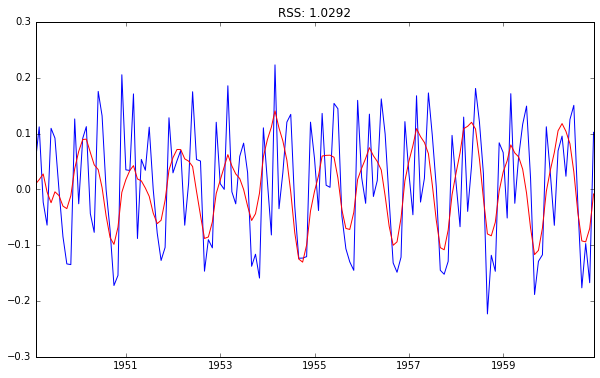

In [45]:
## Combined Model
model = ARIMA(ts_log, order=(2, 1, 2))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_log_diff)**2))


### Taking it back to original scale: 
Since the combined model gave best result, lets scale it back to the original values and see how well it performs there. First step would be to store the predicted results as a separate series and observe it.


In [46]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print predictions_ARIMA_diff.head()

Month
1949-02-01    0.009580
1949-03-01    0.017491
1949-04-01    0.027670
1949-05-01   -0.004521
1949-06-01   -0.023889
dtype: float64


Notice that these start from ‘1949-02-01’ and not the first month. Why? This is because we took a lag by 1 and first element doesn’t have anything before it to subtract from. The way to convert the differencing to log scale is to add these differences consecutively to the base number. An easy way to do it is to first determine the cumulative sum at index and then add it to the base number. The cumulative sum can be found as:

In [47]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print predictions_ARIMA_diff_cumsum.head()

Month
1949-02-01    0.009580
1949-03-01    0.027071
1949-04-01    0.054742
1949-05-01    0.050221
1949-06-01    0.026331
dtype: float64


In [48]:
predictions_ARIMA_log = pd.Series(ts_log.iloc[0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

Month
1949-01-01    4.718499
1949-02-01    4.728079
1949-03-01    4.745570
1949-04-01    4.773241
1949-05-01    4.768720
dtype: float64

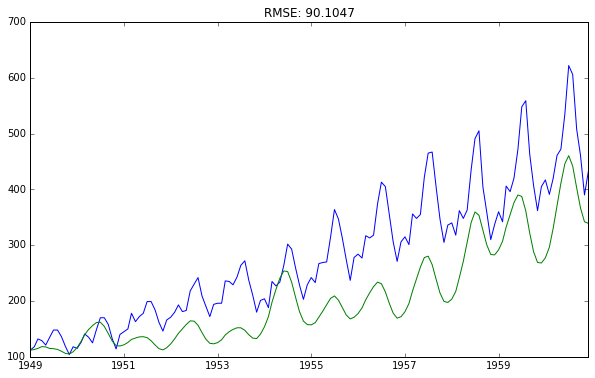

In [49]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(ts)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-ts)**2)/len(ts)))